# Host Filtering Assessment

Filtering the barley genome from NT metagenomic reads was observed to bias taxonomic classifications, with a reduction in Firmicutes. Let's try to work out why...

## Barley Genome

We can use the Morex V3 assembly which includes PacBio HiFi reads, and so is less likely to have bacterial contaminants in the assembly than Morex V2 which was used for the previous analysis. 

In [1]:
import urllib3
import shutil
import subprocess
import os
import re
from glob import glob
import pysam
import matplotlib.pyplot as plt
import numpy as np

In [14]:
os.mkdir('reference')
http = urllib3.PoolManager()

fasta_url='https://doi.ipk-gatersleben.de/DOI/b2f47dfb-47ff-4114-89ae-bad8dcc515a1/b6e6a2e5-2746-4522-8465-019c8f56df7f/1/DOWNLOAD'
annot_url='https://doi.ipk-gatersleben.de/DOI/b2f47dfb-47ff-4114-89ae-bad8dcc515a1/5d16cc17-c37f-417f-855d-c5e72c721f6c/1/DOWNLOAD'
fasta_path='reference/Barley_MorexV3_psuedomolecules.fasta'
annot_path='reference/Barley_MorexV3_psuedomolecules.gff3'
    
print('Downloading {}'.format(fasta_url))
with http.request('GET',fasta_url, preload_content=False) as resp, open(fasta_path, 'wb') as out_file:
    shutil.copyfileobj(resp, out_file)
r.release_conn()

print('Downloading {}'.format(annot_url))
with http.request('GET',annot_url, preload_content=False) as resp, open(annot_path, 'wb') as out_file:
    shutil.copyfileobj(resp, out_file)
r.release_conn()

Now we can build a BWA index...

In [19]:
os.mkdir('bwa')
os.mkdir('logs')
bwa_path='bwa/MorexV3'
os.symlink('../'+fasta_path,bwa_path)

process=subprocess.Popen(['bwa','index',bwa_path],
    stdout=subprocess.PIPE,
    stderr=subprocess.PIPE)
stdout,stderr = process.communicate()

with open('logs/bwa_morex_v3_index.out','w') as stdout_file:
    stdout_file.write(stdout.decode('UTF-8'))

with open('logs/bwa_morex_v3_index.err','w') as stderr_file:
    stderr_file.write(stderr.decode('UTF-8'))

...and symlink in the original QC'd fastq files...

In [15]:
files=glob('../GO_enrichment/read_qc/trim_galore/*gz')
if not os.path.exists('fastq'):
    os.mkdir('fastq')

fq_re=re.compile(r'([0-9]{4}_[12])_val_[12].fq.gz')
for file in files:
    m=re.search(fq_re,file)
    os.symlink('../'+file,'fastq/{}.fq.gz'.format(m.group(1)))

In [18]:
%%bash
cat bin/align_and_filter.sh
#qsub bin/align_and_filter.sh

#!/bin/env bash

#$ -pe smp 24
#$ -jc long
#$ -mods l_hard h_vmem 32G
#$ -j y
#$ -o logs/$JOB_NAME.$JOB_ID.$TASK_ID
#$ -cwd 
#$ -t 1-12:1

readarray -t samples < <(ls -1 fastq|cut -f1 -d_|sort -u)
sample=${samples[$SGE_TASK_ID-1]}

mkdir -p bwa_alignments
mkdir -p filtered_fastq

cp -rv bwa/* $TMPDIR/
cp -v fastq/${sample}* $TMPDIR
bwa mem -t 24 -M $TMPDIR/MorexV3 $TMPDIR/${sample}_1.fq.gz $TMPDIR/${sample}_2.fq.gz |\
	samtools view -b -o $TMPDIR/${sample}.bam
samtools sort -@ 24 --write-index -o $TMPDIR/${sample}.sorted.bam $TMPDIR/${sample}.bam
samtools fastq -F 12 -f 2 -N -1 $TMPDIR/${sample}.filtered_1.fq.gz -2 $TMPDIR/${sample}.filtered_2.fq.gz \
	-0 /dev/null $TMPDIR/${sample}.sorted.bam

cp -v ${TMPDIR}/${sample}.sorted* bwa_alignments
cp -v ${TMPDIR}/${sample}.filtered* filtered_fastq

### Mapping Results

In [92]:
samples={'bulk':['2000','2001','2002'], 'elite':['2023','2024','2025']}

tot_re=re.compile(r'^([0-9]+) \+ [0-9]+ in total')
map_re=re.compile(r'([0-9]+) \+ [0-9]+ mapped')

labels=[]
totals=[]
mapped=[]

for sample in samples.keys():
    for rep in samples[sample]:   
        print(rep)
        labels.append(rep)
        flagstat=pysam.flagstat("bwa_alignments/{}.sorted.bam".format(rep))
        m=re.search(tot_re,flagstat)
        totals.append(m.group(1))
    
        m=re.search(map_re,flagstat)
        mapped.append(m.group(1))
        


2000
2001
2002


IOStream.flush timed out


2023
2024
2025


IOStream.flush timed out


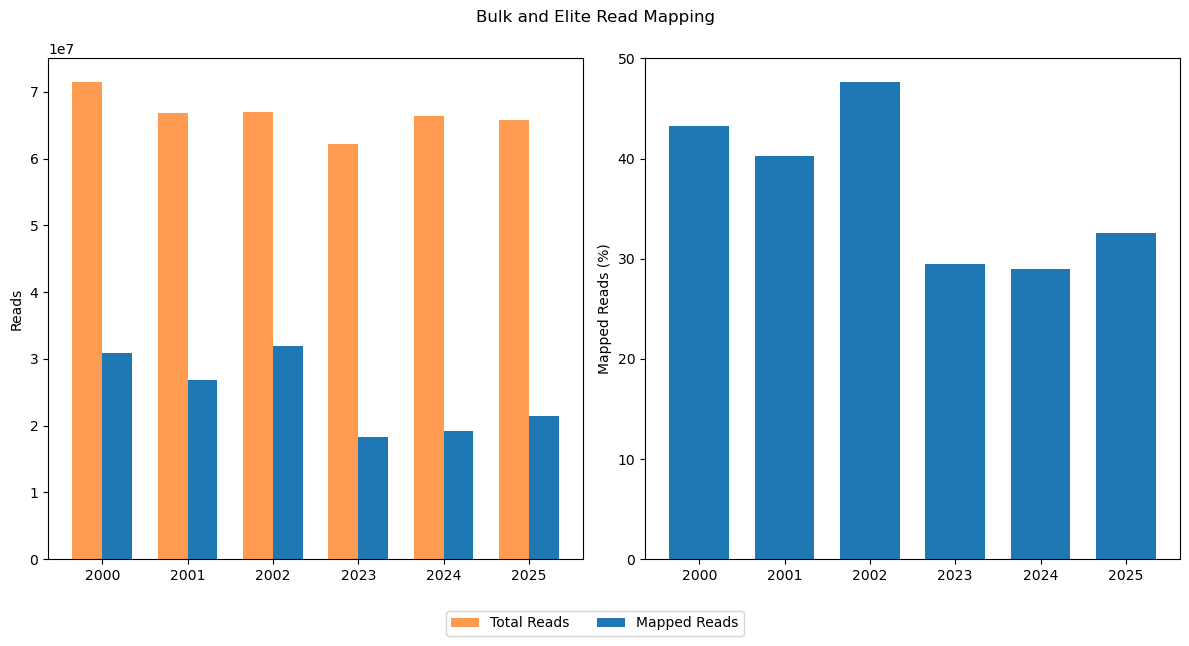

In [97]:

totals=[int(x) for x in totals]
mapped=[int(x) for x in mapped]
percents=[]
for i in range(6):
    percents.append((mapped[i]/totals[i])*100)

x=np.arange(len(labels))
width=0.35

plt.rcParams['figure.figsize'] = [12, 6]
plt.rcParams['figure.dpi'] = 100

fig, (ax1,ax2) = plt.subplots(1,2)
rects1 = ax1.bar(x - width/2, totals, width, color=(1, 0.607, 0.314, 1),label='Total Reads')
rects2 = ax1.bar(x + width/2, mapped, width, label='Mapped Reads')

ax1.set_ylabel('Reads')
ax1.set_xticks(x)
ax1.set_xticklabels(labels)
ax1.ticklabel_format(axis='y',style='sci')

rects3 = ax2.bar(x,percents,width*2)
ax2.set_xticks(x)
ax2.set_xticklabels(labels)
ax2.set_ylabel('Mapped Reads (%)')


fig.suptitle('Bulk and Elite Read Mapping')
fig.legend(loc='upper center',bbox_to_anchor=(0.5,-0.01),ncol=2)
fig.tight_layout()

plt.show()

## Kraken

We can now classify both the filtered and unfiltered reads with Kraken2 and the kraken2_pluspfp database.

In [21]:
%%bash
cat bin/kraken.sh

#!/bin/env bash

#$ -pe smp 24
#$ -mods l_hard mfree 96G
#$ -j y
#$ -o logs/$JOB_NAME.$JOB_ID.$TASK_ID
#$ -cwd
#$ -t 1-12

set -e

# Runs kraken2 against paired fastq reads, where read filenames start with the sample followed by a '_'.

# This script is designed to be run as an array job on an SGE cluster 
# which has local disk storage available on execution nodesaccessed via $TMPDIR, 

usage="Usage: $0 -i /path/to/input/fastq/directory -o /path/to/output/directory -d path/to/kraken_db" 

while getopts "i:o:d:" opt; do
  case "${opt}" in
	i )
		in_dir=${OPTARG}
		;;
	o )
	  out_dir=${OPTARG}
	  ;;
	d )
		db=${OPTARG}
	  ;;
	\? )
		echo ${usage}
	  ;;
	: )
		echo "Invalid option: $OPTARG requires an argument" 1>&2
	;;
  esac
done

if [[ ! -e "${in_dir}" ]]; then
	echo "Specificed input directory (${indir}) does not exist"
	exit
fi

if [[ ! -e "${db}" ]]; then
	echo "Specificed kraken database (${db}) does not exist"
	exit
fi

if [[ -z "${SGE_TASK_ID}" ]]; then
  echo "This script shoul

In [ ]:
%%bash
qsub bin/kraken.sh -i fastq -o kraken/nt_unfiltered -d /cluster/db/jabbott/training_data/kraken2_pluspfp_20210127/
qsub bin/kraken.sh -i filtered_fastq -o kraken/nt_morex3 -d /cluster/db/jabbott/training_data/kraken2_pluspfp_20210127/

### Create Krona outputs

In [ ]:
%%bash
mkdir -p kraken/krona
cd kraken/nt_unfiltered
ktImportTaxonomy -i -m 3 -t 5 -c 2000.report.txt 2001.report.txt  2002.report.txt -o ../krona/nt_unfiltered_bulk.html
ktImportTaxonomy -i -m 3 -t 5 -c 2023.report.txt 2024.report.txt  2025.report.txt -o ../krona/nt_unfiltered_elite.html

cd ../nt_morex3
ktImportTaxonomy -i -m 3 -t 5 -c 2000.report.txt 2001.report.txt  2002.report.txt -o ../krona/nt_morex3_bulk.html
ktImportTaxonomy -i -m 3 -t 5 -c 2023.report.txt 2024.report.txt  2025.report.txt -o ../krona/nt_morex3_elite.html


__Results__

* [Unfilted Bulk](kraken/krona/nt_unfiltered_bulk.html)
* [Unfiltered Elite](kraken/krona/nt_unfiltered_elite.html)
* [Morex3 filtered Bulk](kraken/krona/nt_morex3_bulk.html)
* [Morex3 filtered Elite](kraken/krona/nt_morex3_elite.html)